In [1]:
include("F_calculations.jl");

In [2]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

# Mass method
DSNB(E, z0, i, nubar, ordering, bh_frac, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]

# νe method
function DSNB(E, z0, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB(E, z0, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB(E, z0, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB(E, z0, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end


# Separating the progenitors: 1pc ≡ one progenitor contribution

function DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)
    c0 = 3e8 # m s^(-1)
    # Adding in this integrated mass function so we can multiply by bh fractions at the end
    return 0.00208 * ηAD(125, 8) * (c0*normchoice*SFR(z)/Hubble(z)) * Fmass(E*(1+z)/(1+z0), i, sm, ordering, nubar)
end

DSNB_1pc(E, z0, i, nubar, ordering, sm, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice), z0, 5, rtol=1e-2)[1]

function DSNB_1pc(E, z0, nubar, ordering, sm, normchoice)
    ν1 = DSNB_1pc(E, z0, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_1pc(E, z0, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_1pc(E, z0, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;


# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
lefftrue = extrapolate(leff_ne, 0.0)

# Approximating with a 14 degree polynomial

# Procedure for fitting the polynomial
#=
xsvec = range(0, 5, 100)
leffsvec = 70*leff.(xsvec)

p = Polynomials.fit(xsvec, leffsvec, 14)
=#

function leff(x) 
    if x == 0.0
        return 0.0
    else
        (3.844126829887412e-6 + 0.9994711237154343*x - 1.2171757160998375*x^2 + 1.2011732904692138*x^3 - 1.0258795580085436*x^4 + 0.7535135022231549*x^5 - 0.4576091931617817*x^6 + 0.2207326320476638*x^7 - 0.0820545498767346*x^8 + 0.022953521018636694*x^9 - 0.004712524469463747*x^(10) + 0.0006858791896371295*x^(11) - 6.682066367256103e-5*x^(12) + 3.9015397017829775e-6*x^(13) - 1.0310563080271216e-7*x^(14))/70
    end
end

# Decay function 
function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end


# This function returns the redshift point where the decay function has attenuated by 
# roughly two orders of magnitude, and if we break the integral bounds at this point the integral might run faster
# with QuadGK.jl
function zcutoff(E, α, z0)
    innerpart = 0.007+(E/(4.68e28*α))*log(0.01*exp(-4.68e28*α*leff(z0)/E))
    if innerpart > 0.0
        return -0.555*(log(350*(innerpart))-0.9)
    else
        return 0.0
    end
end;


# Invisible decay implementation

# Mass method
function DSNB_idecay(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

# νe method
function DSNB_idecay(E, z0, α1, α2, α3, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, z0, α1, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, z0, α2, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, z0, α3, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end

# Single progenitor versions
function DSNB_idecay_1pc(E, z0, α, i, nubar, ordering, sm, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

function DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, sm, normchoice)
    ν1 = DSNB_idecay_1pc(E, z0, α1, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, z0, α2, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, z0, α3, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [3]:
@time DSNB_idecay(1, 0, 10^(-24), 0.0, 0.0, true, "NO", "21", SNRnorm)

  1.212328 seconds (641.76 k allocations: 41.629 MiB, 1.25% gc time, 99.95% compilation time)


In [6]:
# Energy spectrum function for SH case
function ψSH(Eh, El, hc)
    if hc
        return 2*El/Eh^2
    else
        return (2/Eh)*(1-(El/Eh))
    end
end

# 3ν IO treatment (2 → 1 QD, 2/1 → 3 SH)

# Case A
# ν2 → ν1, ν2 → ν3, no ν1 → ν3:
# B_21 = 0.5 (no hf), B_23 = 0.25, B_13 = 0
# NB: here if we want to only consider visible decays, we should set α1 to 0 always

# Case B
# ν2 → ν1, ν1 → ν3, no ν2 → ν3:
# B_21 = 1 (no hf), B_13 = 0.5, B_23 = 0

# Case C
# ν2 → ν3, ν1 → ν3, no ν2 → ν1
# B_23 = 0.5, B_13 = 0.5, B_21 = 0

# Democratic
# ν2 → ν3, ν1 → ν3, ν2 → ν1
# B_21 = B_23 = 1/3, B_13 = 0.5

# Note: supposing validity of SH and QD approximations, branching ratios are set in B and C

function branching_3ν_IO(casechoice, j, jbar, i, ibar)
    if casechoice == "A"
        if j == 2 && i == 1 && jbar == ibar
            return 0.5
        elseif j == 2 && i == 3
            return 0.25
        else
            return 0.0
        end
    elseif casechoice == "B"
        if j == 2 && i == 1 && jbar == ibar
            return 1.0
        elseif j == 1 && i == 3
            return 0.5
        else 
            return 0.0
        end
    elseif casechoice == "C"
        if j == 2 && i == 3
            return 0.5
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    elseif casechoice == "democratic"
        if (j == 2 && i == 1 && jbar == ibar) || (j == 2 && i == 3)
            return 1/3
        elseif j == 1 && i == 3
            return 0.5
        else
            return 0.0
        end
    else
        return 0.0
    end
end

function q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z)) *  DSNB_idecay(Ers, z, α2, 2, nubar, "IO", bh_frac, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, nubar, 1, nubar)/Ers)
end

function DSNB_vdecay_1_IO(E, z0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    if casechoice == "A"
        α1 = 0
    end
    integrand(z) = (DSNB_integrand(E, z0, z, 1, nubar, "IO", bh_frac, normchoice) +
                        q21contrib_IO(E, z0, z, α2, nubar, casechoice, bh_frac, normchoice))*decay(E, α1, z0, z)
    zcut = zcutoff(E, α1, z0)
    if zcut > z0 && zcut < 5 && decay(E, α1, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q23contrib_IO(E, z0, z, α2, twobar, threebar, casechoice, bh_frac, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay(Eprime, z, α2, 2, twobar, "IO", bh_frac, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function q13contrib_IO(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν_IO(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function q13contrib_IO_test(E, z0, z, α2, α1, onebar, threebar, casechoice, bh_frac, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO(Eprime, z, α2, α1, onebar, casechoice, bh_frac, normchoice) * (α1 * branching_3ν_IO(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50
    #=
    if Emax > 100
        return quadgk(Eprime -> integrand(Eprime), Ers, 100, Inf, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime), Ers, Emax, rtol=1e-2)[1]
    end
    =#
    return quadgk(u -> integrand(u*(1+z))*(1+z), E/(1+z0), (E/(1+z0))+50, rtol=1e-2)[1]
end

function DSNB_vdecay_3_IO(E, α2, α1, threebar, casechoice, bh_frac, normchoice)
    integrand(z) = (DSNB_integrand(E, 0, z, 3, threebar, "IO", bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, true, threebar, casechoice, bh_frac, normchoice)
                    + q23contrib_IO(E, 0, z, α2, false, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, true, threebar, casechoice, bh_frac, normchoice)
                    + q13contrib_IO(E, 0, z, α2, α1, false, threebar, casechoice, bh_frac, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)

    ν3 = DSNB_vdecay_3_IO(E, α2, α1, nubar, casechoice, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, 0, α2, 2, nubar, "IO", bh_frac, normchoice)
    ν1 = DSNB_vdecay_1_IO(E, 0, α2, α1, nubar, casechoice, bh_frac, normchoice)
    
    return Usqred("IO")[1, 1]*ν1 + Usqred("IO")[1, 2]*ν2 + Usqred("IO")[1, 3]*ν3
end

#######################################

# Per progenitor:

function q21contrib_IO_1pc(E, z0, z, α2, nubar, casechoice, sm, normchoice)

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    return qnorm * (c0/Hubble(z)) *  DSNB_idecay_1pc(Ers, z, α2, 2, nubar, "IO", sm, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, nubar, 1, nubar)/Ers)
end

function DSNB_vdecay_1_IO_1pc(E, z0, α2, α1, nubar, casechoice, sm, normchoice)
    if casechoice == "A"
        α1 = 0
    end
    integrand(z) = (DSNB_integrand_1pc(E, z0, z, 1, nubar, "IO", sm, normchoice) +
                        q21contrib_IO_1pc(E, z0, z, α2, nubar, casechoice, sm, normchoice))*decay(E, α1, z0, z)
    zcut = zcutoff(E, α1, z0)
    if zcut > z0 && zcut < 5 && decay(E, α1, z0, zcut) < 0.1
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return (1/(1+z0)) * quadgk(z -> integrand(z), z0, 5, rtol=1e-2)[1]
    end
end

function q23contrib_IO_1pc(E, z0, z, α2, twobar, threebar, casechoice, sm, normchoice)

    if twobar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_idecay_1pc(Eprime, z, α2, 2, twobar, "IO", sm, normchoice) * (α2 * branching_3ν_IO(casechoice, 2, twobar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function q13contrib_IO_1pc(E, z0, z, α2, α1, onebar, threebar, casechoice, sm, normchoice)

    if onebar == threebar
        hc = true
    else
        hc = false
    end

    Ers = E*(1+z)/(1+z0)

    qnorm = 3.086e19 * 1.516e15 * 1e6 / (3e8 * 1e12)
    integrand(Eprime, z) = qnorm * (c0/Hubble(z))*DSNB_vdecay_1_IO_1pc(Eprime, z, α2, α1, onebar, casechoice, sm, normchoice) * (α1 * branching_3ν_IO(casechoice, 1, onebar, 3, threebar)/Eprime) * ψSH(Eprime, Ers, hc)

    Emax = Ers + 50

    Ecutoff = 1.5*100^(1/3)*Ers
    if Ecutoff < Emax && (ψSH(Ecutoff, Ers, hc)/Ecutoff)/(ψSH(Ers, Ers, hc)/Ers) < 0.1
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Ecutoff, Emax, rtol=1e-2)[1]
    else
        return quadgk(Eprime -> integrand(Eprime, z), Ers, Emax, rtol=1e-2)[1]
    end
end

function DSNB_vdecay_3_IO_1pc(E, α2, α1, threebar, casechoice, sm, normchoice)
    integrand(z) = (DSNB_integrand_1pc(E, 0, z, 3, threebar, "IO", sm, normchoice)
                    + q23contrib_IO_1pc(E, 0, z, α2, true, threebar, casechoice, sm, normchoice)
                    + q23contrib_IO_1pc(E, 0, z, α2, false, threebar, casechoice, sm, normchoice)
                    + q13contrib_IO_1pc(E, 0, z, α2, α1, true, threebar, casechoice, sm, normchoice)
                    + q13contrib_IO_1pc(E, 0, z, α2, α1, false, threebar, casechoice, sm, normchoice))
    return quadgk(z -> integrand(z), 0, 5, rtol=1e-2)[1]
end

function DSNB_vdecay_3ν_νe_IO_1pc(E, α2, α1, nubar, casechoice, sm, normchoice)

    ν3 = DSNB_vdecay_3_IO_1pc(E, α2, α1, nubar, casechoice, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, 0, α2, 2, nubar, "IO", sm, normchoice)
    ν1 = DSNB_vdecay_1_IO_1pc(E, 0, α2, α1, nubar, casechoice, sm, normchoice)
    
    return Usqred("IO")[1, 1]*ν1 + Usqred("IO")[1, 2]*ν2 + Usqred("IO")[1, 3]*ν3
end;

# Free black hole fraction:

function DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, sm, normchoice)
    ν1 = DSNB_idecay_1pc(E, z0, α1, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, z0, α2, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, z0, α3, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

# bh_frac could be anywhere from 0 to 0.41
function DSNB_freefbh(E, z0, nubar, ordering, fbh, normchoice)
    dsnb_small = DSNB_1pc(E, z0, nubar, ordering, "small", normchoice)
    dsnb_large = DSNB_1pc(E, z0, nubar, ordering, "large", normchoice)
    dsnb_bh = DSNB_1pc(E, z0, nubar, ordering, "bh", normchoice)

    fsmall = ηAD(15, 8)/ηAD(125, 8)
    return fsmall*dsnb_small + fbh*dsnb_bh + (1-fsmall-fbh)*dsnb_large
end

function DSNB_idecay_freefbh(E, z0, α1, α2, α3, nubar, ordering, fbh, normchoice)
    dsnb_small = DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, "small", normchoice)
    dsnb_large = DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, "large", normchoice)
    dsnb_bh = DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, "bh", normchoice)

    fsmall = ηAD(15, 8)/ηAD(125, 8)
    return fsmall*dsnb_small + fbh*dsnb_bh + (1-fsmall-fbh)*dsnb_large
end;

In [7]:
es_dsnb = range(0.5, 40, 100);

In [8]:
# Case C: jobid = 45628098
# Case B: jobid = 45623263
# Case D: jobid = 45633812
function create_flux_dict_C()
    dsnb_fluxes_IO_C = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_C/array_output_45628098_$i.txt"
        file_content = read(filepath, String)
        parsed_data = Meta.parse(file_content)
        prog = parsed_data.args[2].args[1]
        logα1 = log10(parsed_data.args[2].args[2])
        logα2 = log10(parsed_data.args[2].args[3])
        dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
        dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

        dsnb_fluxes_IO_C[(prog, true, logα1, logα2)] = dsnb_nubar
        dsnb_fluxes_IO_C[(prog, false, logα1, logα2)] = dsnb_nu
    end
    return dsnb_fluxes_IO_C
end;
function create_flux_dict_B()
    dsnb_fluxes_IO_B = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_B/array_output_45623263_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_B[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_B[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_B[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_B[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    return dsnb_fluxes_IO_B
end;
function create_flux_dict_D()
    dsnb_fluxes_IO_D = Dict{Tuple{String, Bool, Float64, Float64},Vector{Float64}}()
    for i in 1:507
        filepath = "Data/dsnb_IO_raw_data/outputs_D/array_output_45633812_$i.txt"
        file_content = read(filepath, String)
        if file_content == ""
            dsnb_fluxes_IO_D[("error", true, 0.0, 0.0)] = zeros(100)
            dsnb_fluxes_IO_D[("error", false, 0.0, 0.0)] = zeros(100)
        else
            parsed_data = Meta.parse(file_content)
            prog = parsed_data.args[2].args[1]
            logα1 = log10(parsed_data.args[2].args[2])
            logα2 = log10(parsed_data.args[2].args[3])
            dsnb_nubar = [parsed_data.args[3].args[1].args[i] for i in 1:100]
            dsnb_nu = [parsed_data.args[3].args[2].args[i] for i in 1:100]

            dsnb_fluxes_IO_D[(prog, true, logα1, logα2)] = dsnb_nubar
            dsnb_fluxes_IO_D[(prog, false, logα1, logα2)] = dsnb_nu
        end
    end
    return dsnb_fluxes_IO_D
end;

In [9]:
dsnb_fluxes_IO_C_dict = create_flux_dict_C()
dsnb_fluxes_IO_B_dict = create_flux_dict_B()
dsnb_fluxes_IO_D_dict = create_flux_dict_D();

In [10]:
function dsnb_3ν_IO_freefbh_precomp(logα1, logα2, nubar, casechoice, fbh)

    fsmall = ηAD(15, 8)/ηAD(125, 8)
    flarge = 1 - fsmall - fbh

    if casechoice == "B"
        return fsmall*dsnb_fluxes_IO_B_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_B_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_B_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "C"
        return fsmall*dsnb_fluxes_IO_C_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_C_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_C_dict[("bh", nubar, logα1, logα2)]
    elseif casechoice == "D"
        return fsmall*dsnb_fluxes_IO_D_dict[("small", nubar, logα1, logα2)] .+ flarge*dsnb_fluxes_IO_D_dict[("large", nubar, logα1, logα2)] .+ fbh*dsnb_fluxes_IO_D_dict[("bh", nubar, logα1, logα2)]
    else
        return zeros(100)
    end
end

function dsnb_3ν_IO_freefbh(E, logα1, logα2, nubar, casechoice, fbh)
    es = range(0.5, 40, 100)
    dsnb_interp = Interpolations.interpolate((vec(es),), dsnb_3ν_IO_freefbh_precomp(logα1, logα2, nubar, casechoice, fbh), Gridded(Linear()))
    return dsnb_interp(E)
end;

In [11]:
# Detector stuff now

# Energy resolution
function δ(Ee, experiment, channel)
    if experiment == "HK"
        if channel == "IBD"
            return 0.1*sqrt(Ee)
        elseif channel == "ES"
            return 0.0349*Ee + 0.376*sqrt(Ee) - 0.123
        else
            return println("error")
        end
    else
        return println("error")
    end
end

ϵIBD = 0.67
NtIBD = 2.5e34
Δ = mass_neutron - mass_proton

# Response function
K(u, v, experiment, channel) = (1/(δ(v, experiment, channel)*sqrt(2*π)))*exp(-((u-v)/(δ(v, experiment, channel)*sqrt(2)))^2)
σIBD(Eν) = 10^(-43) * sqrt((Eν - Δ)^2 - mass_e^2)*(Eν - Δ)*Eν^(-0.07056 + 0.02018*log(Eν) - 0.001953*(log(Eν)^3))

function expnew(x)
    if exp(x) == Inf
        return 1e30
    else
        return exp(x)
    end
end

# Antiderivative wrt v (which is e_reco)
antiKIBD(u, v) = 0.5*(1 - erf((5*sqrt(2)*(u-v))/sqrt(v)) + expnew(200*u)*(erf((5*sqrt(2)*(u+v))/sqrt(v)) - 1))

binint_KIBD(Eetrue, Eereco_min, Eereco_max) = antiKIBD(Eetrue, Eereco_max) - antiKIBD(Eetrue, Eereco_min)


# Just focusing on ν3 decay rn
function diff_event_rate_IBD(Ee, α1, α2, visible, casechoice, ordering, fbh, normchoice)
    Eν = Ee + Δ
    if α1 == 0.0 && α2 == 0.0
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_freefbh(Eν, 0.0, true, ordering, fbh, normchoice)
    elseif visible && ordering == "IO"
        return ϵIBD * NtIBD * σIBD(Eν) * dsnb_3ν_IO_freefbh(Eν, log10(α1), log10(α2), true, casechoice, fbh)
    elseif visible && ordering == "NO"
        return println("error: haven't implemented this yet")
    else
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_idecay_freefbh(Eν, 0, α1, α2, 0.0, true, ordering, fbh, normchoice)
    end
end

# event_rate_IBD_noeres(Ee_min, Ee_max) = 525600 * 60 * 20 * quadgk(Ee -> diff_event_rate_IBD(Ee), Ee_min, Ee_max)[1]

function event_rate_IBD(Ee_min, Ee_max, α1, α2, visible, casechoice, ordering, fbh, normchoice, yrs)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * yrs * quadgk(Eetrue -> diff_event_rate_IBD(Eetrue, α1, α2, visible, casechoice, ordering, fbh, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end;

In [12]:
@time event_rate_IBD(12, 14, 10^(-24), 10^(-24), true, "B", "IO", 0.21, SNRnorm, 20)

In [41]:
# Reading in the HK backgrounds

ebin_lowerbnds, HK_atmCC_vec = [readdlm("Data/HK_dsnb_backgrounds/HK_atmCC.csv", ',')[:, i] for i in 1:2]
HK_atmNC_vec = readdlm("Data/HK_dsnb_backgrounds/HK_atmNC.csv", ',')[:, 2]
HK_invismuon_vec = readdlm("Data/HK_dsnb_backgrounds/HK_invismuon.csv", ',')[:, 2]
HK_li9spallation_vec = readdlm("Data/HK_dsnb_backgrounds/HK_li9spallation.csv", ',')[:, 2];

In [47]:
emins = 12:2:30
emaxes = 14:2:32

dsnb_hk_nodecay = event_rate_IBD.(emins, emaxes, 0.0, 0.0, false, "B", "NO", 0.21, SNRnorm, 20)
dsnb_hk_nodecay_low = event_rate_IBD.(emins, emaxes, 0.0, 0.0, false, "B", "NO", 0.21, SNRnorm_low, 20)
dsnb_hk_nodecay_high = event_rate_IBD.(emins, emaxes, 0.0, 0.0, false, "B", "NO", 0.21, SNRnorm_high, 20)
dsnb_hk_idecay_24_0_0 = event_rate_IBD.(emins, emaxes, 10^(-24), 0.0, false, "B", "NO", 0.21, SNRnorm, 20)
dsnb_hk_idecay_0_24_0 = event_rate_IBD.(emins, emaxes, 0.0, 10^(-24), false, "B", "NO", 0.21, SNRnorm, 20);

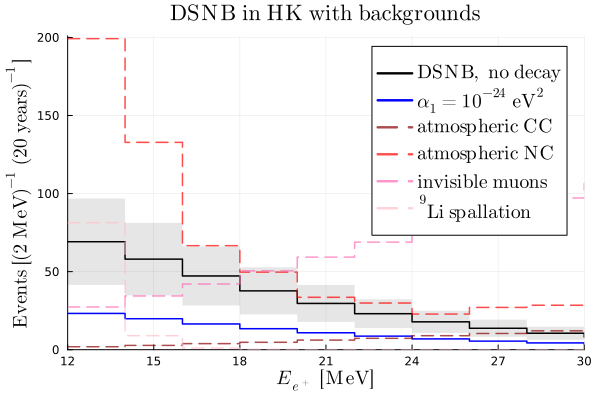

In [31]:
plot(
    emins,
    dsnb_hk_nodecay_low,
    seriestype=:step,
    label=false,
    alpha=0,
    fillrange=dsnb_hk_nodecay_high,
    fillalpha=0.1,
    c=:black
)
plot!(
    emins,
    [dsnb_hk_nodecay dsnb_hk_idecay_24_0_0],
    seriestype=:step,
    c=[:black :blue],
    lw=1.5,
    label=[L"\mathrm{DSNB,~no~decay}" L"\alpha_1 = 10^{-24}~\mathrm{eV^2}"]
)
plot!(
    emins,
    [HK_atmCC_vec HK_atmNC_vec HK_invismuon_vec HK_li9spallation_vec],
    label=[L"\mathrm{atmospheric~CC}" L"\mathrm{atmospheric~NC}" L"\mathrm{invisible~muons}" L"\mathrm{^9Li~spallation}"],
    c=[:darkred :red :hotpink :pink],
    seriestype=:step,
    lw=1.5,
    ls=:dash,
    alpha=0.7,
    xlabel=L"E_{e^+}~[\mathrm{MeV}]",
    ylabel=L"\mathrm{Events~[(2~MeV)^{-1}~(20~years)^{-1}]}",
    title=L"\mathrm{DSNB~in~HK~with~backgrounds}",
    xlims=(12,30),
    ylims=(0,201),
    legendfontsize=13,
    xguidefontsize=13,
    yguidefontsize=13,
    titlefontsize=15,
    margins=2Plots.mm
)

In [233]:
# Start to code up the chi squared test 
using Optim

function background_HK(ebin, ηCC, ηNC, ηiμ, ηLi)
    return ηCC*HK_atmCC_vec[ebin] + ηNC*HK_atmNC_vec[ebin] + ηiμ*HK_invismuon_vec[ebin] + ηLi*HK_li9spallation_vec[ebin]
end

function χ2_unminimized(altsig, nullsig, ξ, ηCC, ηNC, ηiμ, ηLi, σRSN, σn)
    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, ηNC, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 1.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 1+ηNC, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηNC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

function χ2_unminimized_noNC(altsig, nullsig, ξ, ηCC, ηiμ, ηLi, σRSN, σn)
    χperi = zeros(10)
    for i in 1:10
        χperi[i] = (1+ξ)*altsig[i] + background_HK(i, ηCC, 0.0, ηiμ, ηLi) - nullsig[i] + (nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))*log((nullsig[i] + background_HK(i, 1.0, 0.0, 1.0, 1.0))/((1+ξ)*altsig[i] + background_HK(i, 1+ηCC, 0.0, 1+ηiμ, 1+ηLi)))
    end
    return sum(χperi) + (ξ/σRSN)^2 + (ηCC/σn)^2 + (ηiμ/σn)^2 + (ηLi/σn)^2
end

# event_rate_IBD(Ee_min, Ee_max, α1, α2, visible, casechoice, ordering, bh_frac, normchoice, yrs)

function χ2(α1, α2, visible, casechoice, ordering, bh_frac, withNC, σRSN, σn)
    emins = 12:2:30
    emaxes = 14:2:32
    nullDSNB = event_rate_IBD.(emins, emaxes, 0.0, 0.0, false, "B", ordering, bh_frac, SNRnorm, 20)
    altDSNB = event_rate_IBD.(emins, emaxes, α1, α2, visible, casechoice, ordering, bh_frac, SNRnorm, 20)

    if withNC
        optimized = Optim.optimize(x -> χ2_unminimized(altDSNB, nullDSNB, x[1], x[2], x[3], x[4], x[5], σRSN, σn), zeros(5), NelderMead())
    else
        optimized = Optim.optimize(x -> χ2_unminimized_noNC(altDSNB, nullDSNB, x[1], x[2], x[3], x[4], σRSN, σn), zeros(4), NelderMead())
    end
    return optimized.minimum
end;


In [41]:
χ2_unminimized(dsnb_hk_idecay_24_0_0, dsnb_hk_nodecay, 0, 0, 0, 0, 0, 0.2, 0.2)

15.511779846232109

In [252]:
@time χ2(10^(-26.0), 10^(-24.0), true, "B", "IO", "21", true, 0.2, 0.2)

  0.168063 seconds (720.44 k allocations: 13.168 MiB)


0.2720440205236336

In [151]:
αsrange = 10 .^ range(-26.0, -24.0, 11)

chisquareds_IO_idecay = [χ2(α1, α2, false, "B", "IO", "21", false, 0.2, 0.2) for α1 in αsrange, α2 in αsrange]
chisquareds_IO_vdecay_B = [χ2(α1, α2, true, "B", "IO", "21", false, 0.2, 0.2) for α1 in αsrange, α2 in αsrange]
chisquareds_IO_vdecay_C = [χ2(α1, α2, true, "C", "IO", "21", false, 0.2, 0.2) for α1 in αsrange, α2 in αsrange]
chisquareds_IO_vdecay_D = [χ2(α1, α2, true, "D", "IO", "21", false, 0.2, 0.2) for α1 in αsrange, α2 in αsrange];

In [166]:
chisquareds_IO_idecay_betterRSN = [χ2(α1, α2, false, "B", "IO", "21", false, 0.01, 0.2) for α1 in αsrange, α2 in αsrange]
chisquareds_IO_vdecay_B_betterRSN = [χ2(α1, α2, true, "B", "IO", "21", false, 0.01, 0.2) for α1 in αsrange, α2 in αsrange]
chisquareds_IO_vdecay_C_betterRSN = [χ2(α1, α2, true, "C", "IO", "21", false, 0.01, 0.2) for α1 in αsrange, α2 in αsrange]
chisquareds_IO_vdecay_D_betterRSN = [χ2(α1, α2, true, "D", "IO", "21", false, 0.01, 0.2) for α1 in αsrange, α2 in αsrange];

In [253]:
αsrange2 = 10 .^ range(-26.0, -24.0, 22)
chisquareds_IO_idecay_betterRSN_morepts = [χ2(α1, α2, false, "B", "IO", "21", false, 0.2, 0.2) for α1 in αsrange2, α2 in αsrange2];

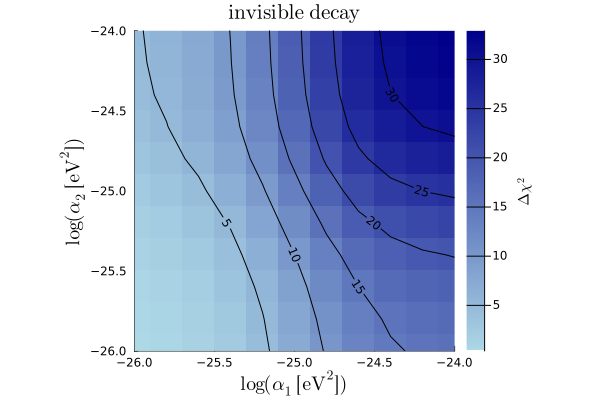

In [281]:
mat = chisquareds_IO_idecay_betterRSN
# mat = chisquareds_IO_idecay
heatmap(
    log10.(αsrange),
    log10.(αsrange),
    transpose(mat), 
    aspect_ratio=1, 
    c=:blues,
    xlims=(-26,-24),
    ylims=(-26,-24),
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    ylabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    colorbartitle=L"\Delta \chi^2",
    title=L"\mathrm{invisible~decay}",
    xguidefontsize=13,
    yguidefontsize=13,
    colorbarfontsize=13
)
contour!(
    log10.(αsrange),
    log10.(αsrange),
    transpose(mat),
    levels=0:5:30,
    lw=1,
    clabels=true,
    c=:black
)

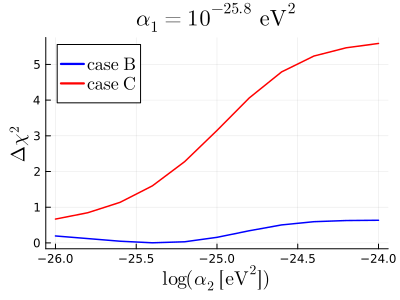

In [292]:
plot(
    range(-26, -24, 11),
    [chisquareds_IO_vdecay_B_betterRSN[2, :] chisquareds_IO_vdecay_C_betterRSN[2, :]],
    lw=1.5,
    c=[:blue :red :blue :red],
    ls=[:solid :solid :dash :dash],
    xlabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    ylabel=L"\Delta\chi^2",
    title=L"\mathrm{\alpha_1 = 10^{-25.8}}~\mathrm{eV^2}",
    label=[L"\mathrm{case~B}" L"\mathrm{case~C}"],
    legendfontsize=12,
    xlabelfontsize=13,
    ylabelfontsize=13,
    titlefontsize=15,
    size=(400,300)
)

In [44]:
logαs_test = range(-27, -22, 100)
αs_test = 10 .^ logαs_test
chisquareds_test_α1_withNC = χ2.(αs_test, 0.0, 0.0, "NO", "21", true, 0.2)
chisquareds_test_α2_withNC = χ2.(0.0, αs_test, 0.0, "NO", "21", true, 0.2)
chisquareds_test_α1_noNC = χ2.(αs_test, 0.0, 0.0, "NO", "21", false, 0.2)
chisquareds_test_α2_noNC = χ2.(0.0, αs_test, 0.0, "NO", "21", false, 0.2)
;

In [50]:
chisquareds_test_α1_withNC_betterRSN = χ2.(αs_test, 0.0, 0.0, "NO", "21", true, 0.01)
chisquareds_test_α2_withNC_betterRSN = χ2.(0.0, αs_test, 0.0, "NO", "21", true, 0.01)
chisquareds_test_α1_noNC_betterRSN = χ2.(αs_test, 0.0, 0.0, "NO", "21", false, 0.01)
chisquareds_test_α2_noNC_betterRSN = χ2.(0.0, αs_test, 0.0, "NO", "21", false, 0.01);

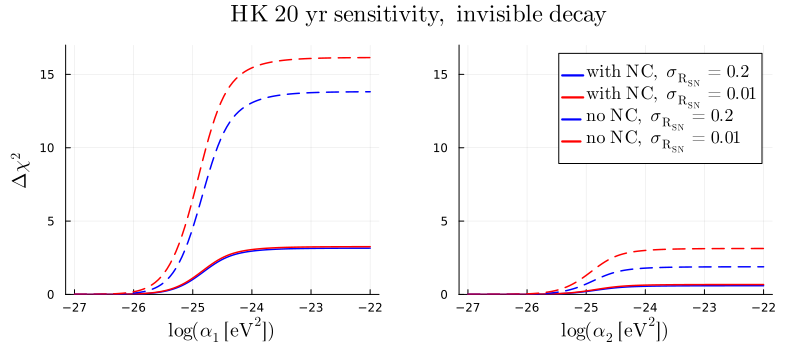

In [77]:
p1 = plot(
    logαs_test,
    [chisquareds_test_α1_withNC chisquareds_test_α1_withNC_betterRSN chisquareds_test_α1_noNC chisquareds_test_α1_noNC_betterRSN],
    lw=1.5,
    c=[:blue :red :blue :red],
    ls=[:solid :solid :dash :dash],
    # label=[L"\mathrm{with~NC,~\sigma_{R_{SN}} = 0.2}" L"\mathrm{with~NC,~\sigma_{R_{SN}} = 0.01}" L"\mathrm{no~NC,~\sigma_{R_{SN}} = 0.2}" L"\mathrm{no~NC,~\sigma_{R_{SN}} = 0.01}"],
    label=false,
    xlabel=L"\log(\alpha_1~[\mathrm{eV^2}])",
    ylabel=L"\Delta\chi^2",
    # title=L"\mathrm{HK~20~yr~sensitivity,~invisible~decay}",
    legendfontsize=12,
    xlabelfontsize=13,
    ylabelfontsize=13,
    titlefontsize=15,
    ylims=(0, 17)
)
p2 = plot(
    logαs_test,
    [chisquareds_test_α2_withNC chisquareds_test_α2_withNC_betterRSN chisquareds_test_α2_noNC chisquareds_test_α2_noNC_betterRSN],
    lw=1.5,
    c=[:blue :red :blue :red],
    ls=[:solid :solid :dash :dash],
    label=[L"\mathrm{with~NC,~\sigma_{R_{SN}} = 0.2}" L"\mathrm{with~NC,~\sigma_{R_{SN}} = 0.01}" L"\mathrm{no~NC,~\sigma_{R_{SN}} = 0.2}" L"\mathrm{no~NC,~\sigma_{R_{SN}} = 0.01}"],
    # label=false,
    xlabel=L"\log(\alpha_2~[\mathrm{eV^2}])",
    # ylabel=L"\Delta\chi^2",
    # title=L"\mathrm{HK~20~yr~sensitivity,~invisible~decay}",
    legendfontsize=12,
    xlabelfontsize=13,
    ylabelfontsize=13,
    titlefontsize=15,
    size=(600,500),
    ylims=(0, 17)
)
plot(p1, p2, plot_title=L"\mathrm{HK~20~yr~sensitivity,~invisible~decay}", layout=(1,2), size=(800,350), margins=5Plots.mm)
